In [96]:
#### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.sparse import csr_matrix as smatrix
import scipy.sparse.linalg as splinalg
import os
import sys
import fem


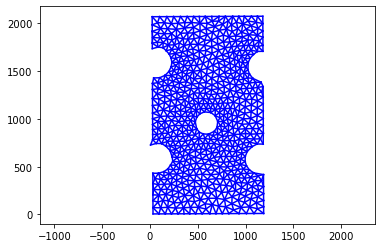

In [97]:
# Units m->pixel=m/pix2m
# Pa=kg/m/s^2->kg/pixel/s^2=Pa*pix2m
# N = kg.m/s^2->kg.pixel/s^2=N/pix2m
# N/m = kg/s^2->kg/s^2=N/m
# Parameters
Ns=10 # Number of loading steps in the FE simulations
pix2m=25.e-6; # pixel to m conversion
thickness=3e-3 # specimen thicness in m
stdu=0.1 # amplitude of the noise on displacement

# Loading FE model and displacement data
npz=np.load('fem-from-dic.npz')
Uref=npz['U']
dUref=stdu*np.random.randn(Uref.size)
Uref+=dUref
Fres=npz['Fres']/thickness
inp='dic-coarse.res'
(X,conn)=fem.readDICmesh(inp)
model=fem.FEModel()
model.X=X
model.conn=conn
model.Assemble()
W=model.W
B=model.B

# Setting the initial material model
Kini=3e8
Eoini=0.3
mat=fem.MatModel(pix2m)
mat.K=Kini
mat.Eo=Eoini
model.material=mat




Xg=0.5*(X[conn[:,0]]+X[conn[:,1]])
Nnodes=X.shape[0]
Nelems=conn.shape[0]
plt.plot(X[conn,0].T,X[conn,1].T,'b-');
plt.axis('equal');

In [98]:
# Boundary conditions for the FE simulation
# Displacement control -> ux,uy from DIC on bottom, ux,uy from DIC on top
# Load control -> ux,uy from DIC on bottom, ux from DIC on top, Fy on top
top=X[:,1]>max(X[:,1])*0.99
bot=X[:,1]<max(X[:,1])*0.01

nodes_index=np.arange(Nnodes)
top_nodes=nodes_index[top]
bot_nodes=nodes_index[bot]
const_ddls_f=np.r_[top_nodes,bot_nodes,bot_nodes+Nnodes]
const_ddls_u=np.r_[top_nodes,top_nodes+Nnodes,bot_nodes,bot_nodes+Nnodes]

Fext=np.zeros(2*Nnodes)
Uimp=np.zeros(2*Nnodes)
Uimp=Uref.copy()
U=np.zeros(2*Nnodes)

Fint=model.Solve(Ns,const_ddls_u,Uimp,Fext,U,True)
#Scaling the traction profile to the experimental Force
print(Fres/sum(Fint[top_nodes+Nnodes]))
scal=Fres/sum(Fint[top_nodes+Nnodes])
Fext[top_nodes+Nnodes]=Fint[top_nodes+Nnodes]*scal
print(Fres/sum(Fext[top_nodes+Nnodes]))

# To check and have a initial displacement field
test=model.Solve(1,const_ddls_f,Uimp,Fext,U,True);
print(Fres/sum(test[top_nodes+Nnodes]))
Uini=U.copy()



Solving...
For load factor 0.100 after 6 iterations R/Fext = 1.000e+00 dU/U=1.878e-08
For load factor 0.200 after 6 iterations R/Fext = 1.000e+00 dU/U=9.335e-08
For load factor 0.300 after 6 iterations R/Fext = 1.000e+00 dU/U=2.558e-07
For load factor 0.400 after 6 iterations R/Fext = 1.000e+00 dU/U=5.386e-07
For load factor 0.500 after 6 iterations R/Fext = 1.000e+00 dU/U=9.736e-07
For load factor 0.600 after 7 iterations R/Fext = 1.000e+00 dU/U=1.264e-07
For load factor 0.700 after 7 iterations R/Fext = 1.000e+00 dU/U=2.234e-07
For load factor 0.800 after 7 iterations R/Fext = 1.000e+00 dU/U=3.664e-07
For load factor 0.900 after 7 iterations R/Fext = 1.000e+00 dU/U=5.668e-07
For load factor 1.000 after 7 iterations R/Fext = 1.000e+00 dU/U=8.370e-07
9.685216751231109e-01
0.9999999999999998

Solving...
For load factor 1.000 after 7 iterations R/Fext = 1.000e+00 dU/U=2.401e-07
9.999999415252058e-01


In [99]:
def updatematerial(P):
    mat=fem.MatModel(pix2m)
    mat.K=Kini*P[0]
    mat.Eo=Eoini*P[1]
    return mat

def sensitivity(P,U):
    dudp = np.zeros((U.shape[0],P.size))
    dP=0.01
    mati=model.material
    Umod=U.copy();

    for ii in range(len(P)):
        Pi=P+0.;
        Pi[ii]=Pi[ii]+dP
        newmat=updatematerial(Pi)
        model.material=newmat
        model.Solve(1,const_ddls_f,Uimp,Fext,Umod,False);
        dudp[:,ii]=(Umod-U)/dP
    model.material=mati
    return dudp

def covariance(dudp):
    C = np.zeros((np.size(dudp,1),np.size(dudp,1)))
    for ii in range(np.size(dudp,1)):
        for jj in range(np.size(dudp,1)):
                C[ii][jj]=np.dot(dudp[:,ii],dudp[:,jj])
    return C


def residual(dudp,r):
    b = np.zeros((np.size(dudp,1)))
    for ii in range(np.size(dudp,1)):
                b[ii]=np.dot(dudp[:,ii],r)
    return b

P=np.array((1.,1.))
#dudp=sensitivity(P, U)
#C=covariance(dudp)   
nIter=10 # number of iteration to perform
for iter in range(nIter):
    # a. compute the sensitivity matrix $dudp$ 
    dudp=sensitivity(P, U)
    # b. compute the covariance matrix $C$
    C=covariance(dudp)    
    # c. compute the residual vector $b$
    b=residual(dudp, Uref-U)
    # d. solve the system $C\; dP=b$ for getting the parameter increment
    dP=np.linalg.solve(C,b)
    #print('C' ,C)
    #print('b',b)
    #print('dP',dP)
    # e. update the parameter values $P=P+dP$
    P+=.9*dP
    # f. update the FE solution $U$ with the updated parameters
    material=updatematerial(P)
    model.material=material
    Fint=model.Solve(1,const_ddls_u,Uimp,Fext,U,False);
    scal=Fres/sum(Fint[top_nodes+Nnodes])
    Fext[top_nodes+Nnodes]=Fint[top_nodes+Nnodes]*scal
    Fint=model.Solve(1,const_ddls_f,Uimp,Fext,U,False);

    # g. compute the norm of the gap between $U$ and $U_{DIC}$
    norm = np.linalg.norm(Uref-U)
    normp = np.linalg.norm(dP)/np.linalg.norm(P)
    print('***FEMU loop Iteration %02d: |U-Uref| =%6.3e  dP/P =%6.4f***' % (iter,norm,normp))

print('IDENTIFIED PARAMETERS\n K = %5.3f MPa,Eo %5.3f' %  (Kini*P[0]*1.e-6,Eoini*P[1] ))
print('REFERENCE PARAMETERS\n K = %5.3f MPa,Eo %5.3f' %  (2e8*1.e-6,0.2 ))



***FEMU loop Iteration 00: |U-Uref| =3.651e+01  dP/P =0.6298***
***FEMU loop Iteration 01: |U-Uref| =5.726e+00  dP/P =0.1062***
***FEMU loop Iteration 02: |U-Uref| =3.796e+00  dP/P =0.0296***
***FEMU loop Iteration 03: |U-Uref| =3.796e+00  dP/P =0.0037***
***FEMU loop Iteration 04: |U-Uref| =3.794e+00  dP/P =0.0006***
***FEMU loop Iteration 05: |U-Uref| =3.794e+00  dP/P =0.0001***
***FEMU loop Iteration 06: |U-Uref| =3.794e+00  dP/P =0.0000***
***FEMU loop Iteration 07: |U-Uref| =3.794e+00  dP/P =0.0000***
***FEMU loop Iteration 08: |U-Uref| =3.794e+00  dP/P =0.0000***
***FEMU loop Iteration 09: |U-Uref| =3.794e+00  dP/P =0.0000***
IDENTIFIED PARAMETERS
 K = 217.399 MPa,Eo 0.219
REFERENCE PARAMETERS
 K = 200.000 MPa,Eo 0.200


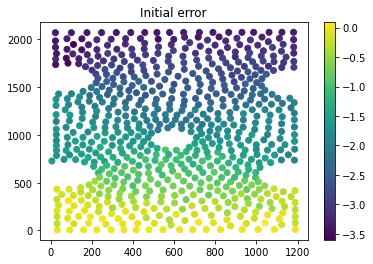

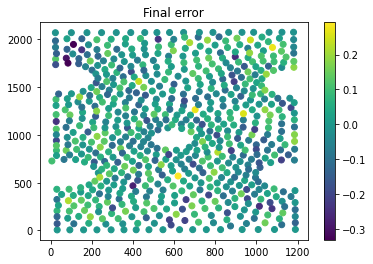

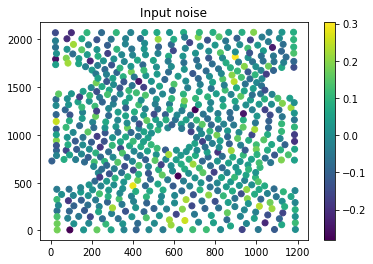

In [100]:
ff=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Uini[Nnodes::]-Uref[Nnodes::])
plt.colorbar()
plt.title('Initial error')
ff=plt.figure()
plt.scatter(X[:,0],X[:,1],c=U[Nnodes::]-Uref[Nnodes::])
plt.colorbar()
plt.title('Final error')
ff=plt.figure()
plt.scatter(X[:,0],X[:,1],c=dUref[Nnodes::])
plt.colorbar()
plt.title('Input noise')

np.savez('femu-from-fem',U=U,mat=model.material)
